<a href="https://colab.research.google.com/github/pizzapuppies/Usif_FYP_code/blob/main/hyper_tuned_concentration_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Updates: 
- joined all the negtive cases 
- 20% val split is better than 10%
- currently trying smote

In [1]:
! pip install -q -U keras-tuner
from google.colab import drive
import pandas as pd 
import os
import tensorflow as tf
import numpy as np  
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import csv
import random
from tensorflow import keras
import sys
from matplotlib import pyplot as plt
import keras_tuner as kt
drive.mount('/content/gdrive')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.3/167.3 KB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 42.5 MB/s eta 0:00:00
Mounted at /content/gdrive


#Data preprocessing

In [2]:
#@title spliting the data
train_test_split = "20%" #@param ["10%", "20%"]
data = []
with open("/content/gdrive/My Drive/data.csv","r") as rfile:
  line = 0

  reader  = csv.reader(rfile)
  real,imag = [],[]

  for i in reader:
      data.append(i)



data = np.array(data)

test,train = [],[]
count = random.randint(0,10)

spl = 10 if train_test_split == '10%' else 5

for i in data:
  if count%spl == 0:  ## This line controls the train_test split (10 for 10%, 5 for 20%)
    test.append(i)
  else: train.append(i) 
  count += 1

test = np.array(test)
train = np.array(train)

with open("train_data.csv","w") as wfile:
  writer = csv.writer(wfile)
  for i in train:
    writer.writerow(i)
with open("test_data.csv","w") as wfile:
  writer = csv.writer(wfile)
  for i in test:
    writer.writerow(i)

the shape of X is (112, 50, 2)


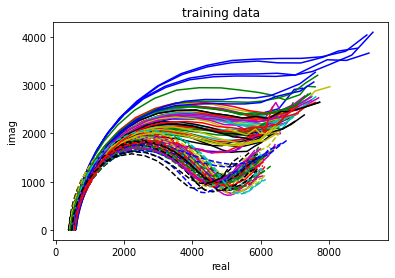

In [5]:
#@title extracting the training data
y = []
x = []

with open("train_data.csv","r") as tfile:
  reader = csv.reader(tfile)
  for i in reader:
    
    y.append(i[0])

    a,b = list(map(float,i[1:51])),list(map(float,i[51:]))
    temp  = []
    for j in range(len(a)):
      temp.append([a[j],b[j]])
    x.append(temp)

x = np.array(x)
y = np.array(y)


temp = list(zip(x, y))
random.shuffle(temp)
x, y = zip(*temp)
x, y = list(x), list(y)
x = np.array(x)
y = np.array(y)

print("the shape of X is",x.shape)

#@title graphing the training data
def seprate_ax(li): # shaped 50,2 => 2,50
  x,y = [],[]
  for i in li:
    x.append(i[0])
    y.append(i[1])
  return [x,y]

#linetp = {"p0.5-1":"b-","n":"r-","p2-4":"k-","p8-32":"m-" }  
linetp = {"p0.5":"b-","n0.5":"b--","p1":"g-","n1":"g--","p2":"r-","n2":"r--","p4":"c-","n4":"c--","p8":"m-","n8":"m-","p16":"y-","n16":"y--","p32":"k-","n32":"k--"} 

for i in range(len(x)):


  li = seprate_ax(x[i])
  try:
    
    plt.plot(li[0],li[1], linetp[y[i]] )
  except: pass
  

plt.title(f"training data")
plt.ylabel("imag")
plt.xlabel("real")
plt.show()


In [7]:


#@title one hot encoding Y

mapping = {}
codes = list(set(y))
codes = ['p8', 'p0.5', 'p16', 'p2', 'p1', 'p4', 'p32',"n"]


l = len(codes)
print(codes)
for i in range(l):
  li = [0]*l
  
  li[i] = 1
  
  mapping[codes[i]] = np.array(li)

temp = []
for i in y:
  if "n" in i:
    temp.append(mapping["n"])  
  else:
    temp.append(mapping[i])

y = np.array(temp)

print("The shape of Y is",y.shape)



['p8', 'p0.5', 'p16', 'p2', 'p1', 'p4', 'p32', 'n']
The shape of Y is (112, 8)


# building and runnning the model

In [8]:
def model_builder(hp):
  model = tf.keras.models.Sequential()
  model.add(keras.layers.Dense(128,         #Number of nodes
                        input_shape=(50,2), #Number of input variables
                        name='Hidden-Layer-1', #Logical name
                        activation='relu'))    #activation function

  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  
  #Add a second hidden layer
  model.add(keras.layers.Dense(units=hp_units,
                                name='Hidden-Layer-2',
                                activation='relu',
                                ))

  #Add a second hidden layer
  model.add(keras.layers.Dense(128,
                                name='Hidden-Layer-3',
                                activation='relu'))



  #Add a second hidden layer
  model.add(keras.layers.Dense(128,
                                name='Hidden-Layer-4',
                              activation='relu'))
  
  model.add(keras.layers.Dense(128,
                                name='Hidden-Layer-5',
                              activation='relu'))
  
  model.add(keras.layers.Dense(128,
                                name='Hidden-Layer-6',
                              activation='relu'))

  model.add(tf.keras.layers.Flatten())
  model.add(keras.layers.Dense(l,
                             name='Output-Layer',
                             activation='softmax'))

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  
  

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=tf.keras.losses.CategoricalCrossentropy(),
                metrics=['accuracy'])

  return model

def learn_test(X_train,Y_train,X_test,Y_test):
  

  tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=100,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')

  stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

  tuner.search(X_train, Y_train, epochs=100, validation_split=0.2, callbacks=[stop_early],verbose = 0)

  # Get the optimal hyperparameters
  best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

  #print(f
  """
  The hyperparameter search is complete. The optimal number of units in the first densely-connected
  layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
  is {best_hps.get('learning_rate')}.
  )"""

 # Build the model with the optimal hyperparameters and train it on the data for 50 epochs
  model = tuner.hypermodel.build(best_hps)
  history = model.fit(X_train, Y_train, epochs=100, validation_split=0.2)

  val_acc_per_epoch = history.history['val_accuracy']
  best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
  print('Best epoch: %d' % (best_epoch,))

  hypermodel = tuner.hypermodel.build(best_hps)

  # Retrain the model
  hypermodel.fit(X_train, Y_train, epochs=best_epoch, validation_split=0.2)

  eval_result = hypermodel.evaluate(X_test, Y_test)
  print("[test loss, test accuracy]:", eval_result)
  return eval_result[1]


# extracting and preapring the testing data 

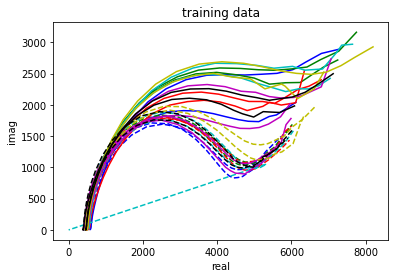

The shape of Y is (28, 8)


In [10]:
y_test = []
x_test = []
with open("test_data.csv","r") as tfile:
  reader = csv.reader(tfile)
  for i in reader:
    
    y_test.append(i[0])
    a,b = list(map(float,i[1:51])),list(map(float,i[51:]))
    temp  = []
    for j in range(len(a)):
      temp.append([a[j],b[j]])
    x_test.append(temp)
  
def seprate_ax(li): # shaped 50,2 => 2,50
  x,y = [],[]
  for i in li:
    x.append(i[0])
    y.append(i[1])
  return [x,y]

linetp = {"p0.5":"b-","n0.5":"b--","p1":"g-","n1":"g--","p2":"r-","n2":"r--","p4":"c-","n4":"c--","p8":"m-","n8":"m-","p16":"y-","n16":"y--","p32":"k-","n32":"k--"} 

for i in range(len(x_test)):
  li = seprate_ax(x_test[i])
  try:
    plt.plot(li[0],li[1], linetp[y_test[i]] )
  except: pass
  
  

plt.title(f"training data")
plt.ylabel("imag")
plt.xlabel("real")
plt.show()


mapping = {}
codes = list(set(y_test))
codes = ['p8', 'p0.5', 'p16', 'p2', 'p1', 'p4', 'p32',"n"]

l = len(codes)

for i in range(l):
  li = [0]*l
  
  li[i] = 1
  
  mapping[codes[i]] = np.array(li)

temp = []
for i in y_test:
  if "n" in i:
    temp.append(mapping["n"])  
  else:
    temp.append(mapping[i])

y_test = np.array(temp)

print("The shape of Y is",y_test.shape)


In [11]:
x_test = np.array(x_test)
y_test = np.array(y_test)


temp = list(zip(x_test, y_test))
random.shuffle(temp)
x_test, y_test = zip(*temp)
x_test, y_test = list(x_test), list(y_test)
x_test = np.array(x)
y_test = np.array(y)
print(y_test.shape)

(112, 8)


# final result

In [12]:
xa = learn_test(x,y,x_test,y_test)

Epoch 1/100
3/3 [==============================] - 2s 182ms/step - loss: 39.4171 - accuracy: 0.2697 - val_loss: 70.0971 - val_accuracy: 0.6087
Epoch 2/100
3/3 [==============================] - 0s 39ms/step - loss: 77.3005 - accuracy: 0.3933 - val_loss: 37.7425 - val_accuracy: 0.6087
Epoch 3/100
3/3 [==============================] - 0s 38ms/step - loss: 48.6132 - accuracy: 0.3483 - val_loss: 21.7401 - val_accuracy: 0.6087
Epoch 4/100
3/3 [==============================] - 0s 45ms/step - loss: 17.8380 - accuracy: 0.4831 - val_loss: 18.7049 - val_accuracy: 0.0435
Epoch 5/100
3/3 [==============================] - 0s 40ms/step - loss: 11.7860 - accuracy: 0.3596 - val_loss: 6.7671 - val_accuracy: 0.6522
Epoch 6/100
3/3 [==============================] - 0s 42ms/step - loss: 11.5770 - accuracy: 0.5393 - val_loss: 5.2471 - val_accuracy: 0.6522
Epoch 7/100
3/3 [==============================] - 0s 41ms/step - loss: 8.0920 - accuracy: 0.5506 - val_loss: 6.2957 - val_accuracy: 0.6957
Epoch 8/1

In [13]:
print("accuracy is ",round(xa*100))

accuracy is  78
